# Analiza mreže javnog gradskog prevoza u Beogradu

### Opis grafa
TODO

Podešavanje okruženja:
+ pip install ipykernel
+ pip install numpy scipy networkx pandas matplotlib
+ pip install scikit-learn python-docx

Linkovi:
+ [Portal otvorenih podataka](https://data.gov.rs/sr/datasets/gtfs/)
+ [General Transit Feed Specification](https://en.wikipedia.org/wiki/GTFS)
+ [Linije javnog prevoza u Beogradu](https://sr.wikipedia.org/sr-el/%D0%9B%D0%B8%D0%BD%D0%B8%D1%98%D0%B5_%D1%98%D0%B0%D0%B2%D0%BD%D0%BE%D0%B3_%D0%BF%D1%80%D0%B5%D0%B2%D0%BE%D0%B7%D0%B0_%D1%83_%D0%91%D0%B5%D0%BE%D0%B3%D1%80%D0%B0%D0%B4%D1%83)
+ [Sekretarijat za javni prevoz](https://www.bgprevoz.rs/)

### Globalne stvari

In [49]:
# importi
from datetime import datetime, date, timedelta
import math
import numpy as np
import scipy.stats as stats
import networkx as nx
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from itertools import chain, combinations
from sklearn.cluster import SpectralClustering
from scipy.cluster.hierarchy import dendrogram


# putanje
original_path = "../data/!original/"
clean_path = "../data/clean/"
graphs_path = "../data/graphs/"

# globalne funkcije

def series_to_single_value(series):
    return series.to_list()[0]

def cleaned_null_columns(df:pd.DataFrame):
    non_null_columns = [column for column in df.columns if not df[column].isna().all()]
    return df[non_null_columns]

def cleaned_duplicates(df:pd.DataFrame):
    no_duplicates = df.drop_duplicates()
    number_of_duplicates = df.shape[0] - no_duplicates.shape[0]
    return no_duplicates

def cleaned_data_frame(df:pd.DataFrame):
    return cleaned_duplicates(cleaned_null_columns(df))


def is_valid_datetime_str(datetime_str):
    format_str = "%H:%M:%S"
    try:
        datetime.strptime(datetime_str, format_str)
        return True
    except ValueError:
        return False
    except TypeError:
        return False

def midnight_converter(datetime_str):
    if (not str.startswith(datetime_str, "24")):
        return datetime_str
    else:
        return "00" + datetime_str[2:]

def safely_remove_edge(G:nx.Graph, edge):
    u, v = edge
    if G.has_edge(u, v):
        G.remove_edge(u, v)

### Čišćenje podataka

In [3]:
# # # Originalni podaci se čuvaju u data/!original/ folderu.
# Prečišćeni podaci se čuvaju u data/clean/ folderu.
# BgNetLWalk podaci se čuvaju u data/consolidate/ folderu.    

# TODO: izabrati koji se podaci koriste za izvršavanje
# ! Komentare koji pocinju sa uzvicnikom ili upitnikom izbaciti iz finalne verzije
df_agency = pd.read_csv(f"{original_path}/agency.csv")
df_calendar_dates = pd.read_csv(f"{original_path}/calendar_dates.csv")
df_calendar = pd.read_csv(f"{original_path}/calendar.csv")
df_fare_attributes = pd.read_csv(f"{original_path}/fare_attributes.csv")
df_fare_rules = pd.read_csv(f"{original_path}/fare_rules.csv")
df_feed_info = pd.read_csv(f"{original_path}feed_info.csv")
df_frequencies = pd.read_csv(f"{original_path}/frequencies.csv")#? Treba li da radimo u opstem slucaju i pravimo da ova tabela postoji, ili je bas poenta da je ignorisemo
df_routes = pd.read_csv(f"{original_path}/routes.csv")
df_shapes = pd.read_csv(f"{original_path}/shapes.csv")
df_stops = pd.read_csv(f"{original_path}/stops.csv")
df_stop_times = pd.read_csv(f"{original_path}/stop_times.csv", dtype={"stop_headsign":np.string_})
df_transfers = pd.read_csv(f"{original_path}/transfers.csv")
df_trips = pd.read_csv(f"{original_path}/trips.csv")




all_frames = [df_agency, df_calendar_dates, df_calendar, df_fare_attributes, df_fare_rules, df_feed_info, df_frequencies, df_routes, df_shapes, df_stops, df_stop_times, df_transfers, df_trips]
all_frames_cleaned = [cleaned_data_frame(df) for df in all_frames]




In [4]:
[df_agency, df_calendar_dates, df_calendar, df_fare_attributes, df_fare_rules, df_feed_info, df_frequencies, df_routes, df_shapes, df_stops, df_stop_times, df_transfers, df_trips] = all_frames_cleaned
df_agency.to_csv(f"{clean_path}/agency.csv", index=False)
df_calendar_dates.to_csv(f"{clean_path}/calendar_dates.csv", index=False)
df_calendar.to_csv(f"{clean_path}/calendar.csv", index=False)
df_fare_attributes.to_csv(f"{clean_path}/fare_attributes.csv", index=False)
df_fare_rules.to_csv(f"{clean_path}/fare_rules.csv", index=False)
df_feed_info.to_csv(f"{clean_path}/feed_info.csv", index=False)
df_frequencies.to_csv(f"{clean_path}/frequencies.csv", index=False)
df_routes.to_csv(f"{clean_path}/routes.csv", index=False)
df_shapes.to_csv(f"{clean_path}/shapes.csv", index=False)
df_stops.to_csv(f"{clean_path}/stops.csv", index=False)
df_stop_times.to_csv(f"{clean_path}/stop_times.csv", index=False)
df_transfers.to_csv(f"{clean_path}/transfers.csv", index=False)
df_trips.to_csv(f"{clean_path}/trips.csv", index=False)

In [5]:
df_agency = pd.read_csv(f"{clean_path}/agency.csv")
df_calendar_dates = pd.read_csv(f"{clean_path}/calendar_dates.csv")
df_calendar = pd.read_csv(f"{clean_path}/calendar.csv")
df_fare_attributes = pd.read_csv(f"{clean_path}/fare_attributes.csv")
df_fare_rules = pd.read_csv(f"{clean_path}/fare_rules.csv")
df_feed_info = pd.read_csv(f"{clean_path}/feed_info.csv")
df_routes = pd.read_csv(f"{clean_path}/routes.csv")
df_shapes = pd.read_csv(f"{clean_path}/shapes.csv")
df_stops = pd.read_csv(f"{clean_path}/stops.csv")
df_stop_times = pd.read_csv(f"{clean_path}/stop_times.csv", dtype={"stop_headsign":np.string_})
df_trips = pd.read_csv(f"{clean_path}/trips.csv")


#print(df_routes["route_type"].unique()) #rezultati (0,3, 702, 800) 0 - tramvaj, 3 - autobus, 702 - ekspres autobus, 800 - trolejbus
route_type_names = {0:"Tramvaj", 3:"Autobus", 702:"Autobus", 800:"Trolejbus"}
df_routes["route_type_name"] = df_routes["route_type"].map(route_type_names)

In [6]:
#TODO: Ovo mozda treba prebaciti u ciscenje podataka
df_stop_times = df_stop_times.loc[df_stop_times["arrival_time"].notna() & df_stop_times["departure_time"].notna()]
df_stop_times["arrival_time"] = df_stop_times["arrival_time"].map(lambda x: midnight_converter(x))
df_stop_times["departure_time"] = df_stop_times["departure_time"].map(lambda x: midnight_converter(x))
#for dep_time in df_stop_times["departure_time"]:
    #if (not is_valid_datetime_str(dep_time)):
        #print(f"Non valid {dep_time}")
is_valid_datetime_str(123)

False

### Statistička obrada podataka [5 poena]
1) Odrediti prosečno vreme između dva polaska svake od linija. Koje su linije sa najčešćim, a koje sa najređim polascima?
2) Koje su linije sa najvećim brojem stanica, a koje stanice sa najvećim brojem linija?
3) Preračunati očekivani dnevni promet stanice kao ukupan očekivani broj stajanja linije na toj stanici, određen na osnovu planiranog rasporeda vožnje. Koje su stanice sa najvećim očekivanim dnevnim prometom?
4) Svakoj stanici dodeliti tip na osnovu vrsta prevoza koje prolaze njom (stanica autobusa, tramvaja, trolejbusa ili meštovita stanica). Koliko ima stanica svakog tipa?

In [6]:
# 1) Odrediti prosečno vreme između dva polaska svake od linija.
# Koje su linije sa najčešćim, a koje sa najređim polascima?

# TODO
def find_average_departure_times_for_stops():
    def get_average_wait(departure_times_str):
        def convert_to_time(time_str):
            time_object = datetime.strptime(time_str, '%H:%M:%S').time()
            return time_object
        departure_times = [convert_to_time(time_str) for time_str in departure_times_str if is_valid_datetime_str(time_str)]
        departure_times = sorted(departure_times)
        average_timedelta = timedelta(0)
        num_elements = len(departure_times)
        for index in range(1, len(departure_times)):
            prev = index - 1
            duration = datetime.combine(date.min, departure_times[index]) - datetime.combine(date.min, departure_times[prev])
            average_timedelta = average_timedelta + duration  
        if num_elements == 0:
            inf = 25*60
            return pd.NA
        average_timedelta = average_timedelta / num_elements
        return average_timedelta 
    
    route_names_dict = df_routes[["route_id", "route_short_name"]].to_dict()

    trips_with_route_name = pd.merge(df_trips, df_routes[["route_id", "route_short_name"]], how="inner", on="route_id")
    stop_times_with_route_id = pd.merge(df_stop_times[["stop_id", "trip_id", "departure_time"]], trips_with_route_name[["trip_id", "route_id", "route_short_name", "service_id"]], how="inner", on="trip_id")[["stop_id", "departure_time", "route_id", "route_short_name", "service_id"]]
    stop_times_with_routes_grouped = stop_times_with_route_id.groupby(["stop_id", "route_id", "route_short_name", "service_id"])["departure_time"].apply(lambda x: get_average_wait(list(x)))
    stop_times_with_route_id_waits = pd.DataFrame(stop_times_with_routes_grouped)
    stop_times_with_routes_sorted = stop_times_with_route_id_waits.sort_values("departure_time")
    stop_times_with_routes_sorted = stop_times_with_routes_sorted.rename(columns={"departure_time":"average_wait"})
    stop_times_with_routes_sorted = stop_times_with_routes_sorted.dropna(subset=["average_wait"])
    stop_times_with_routes_sorted = stop_times_with_routes_sorted[stop_times_with_routes_sorted["average_wait"] != timedelta(0)]#radi za sad
    
    return stop_times_with_routes_sorted

find_average_departure_times_for_stops()

average_wait
stop_id route_id route_short_name service_id                      
2124    50037    37N              Zimski-Nedelja           0:01:00
                                  Zimski-Radni Dan         0:01:00
                                  Zimski-Subota            0:01:00
333     50015    15N              Zimski-Nedelja           0:01:30
1576    50308    308N             Zimski-Radni Dan         0:01:30
...                                                            ...
404     612      612              Zimski-Nedelja           1:32:00
871     54       54               Zimski-Nedelja    1:43:46.153846
                                  Zimski-Subota     1:43:46.153846
873     54       54               Zimski-Subota     1:43:50.769231
                                  Zimski-Nedelja    1:43:50.769231

[24147 rows x 1 columns]

In [ ]:
# 2) Koje su linije sa najvećim brojem stanica, a koje stanice sa najvećim brojem linija?

# TODO
#stops (identified by the name) with routes

# TODO Treba li izvrsiti spajanje stanica pa iskombinovati sa ovim?
# TODO: Malko su sumnjivi rezultati
def find_routes_with_most_stops():
    stop_times_with_route_id = pd.merge(df_stop_times[["stop_id", "trip_id"]], df_trips[["trip_id", "route_id"]], how="inner", on="trip_id")
    route_ids_with_num_stops = stop_times_with_route_id.groupby("route_id")["stop_id"].nunique().reset_index(name='number_of_distinct_stop_ids')
    route_ids_with_max_stops = route_ids_with_num_stops.loc[route_ids_with_num_stops["number_of_distinct_stop_ids"] == route_ids_with_num_stops["number_of_distinct_stop_ids"].max()]
    route_with_most_stops_with_names = pd.merge(df_routes[["route_id", "route_short_name"]], route_ids_with_max_stops, how="inner", on="route_id")
    return route_with_most_stops_with_names


def find_stops_with_most_routes():
    stop_times_with_route_id = pd.merge(df_stop_times[["stop_id", "trip_id"]], df_trips[["trip_id", "route_id"]], how="inner", on="trip_id")
    stop_ids_with_num_routes = stop_times_with_route_id.groupby("stop_id")["route_id"].nunique().reset_index(name='number_of_distinct_route_ids')
    stops_with_most_routes = stop_ids_with_num_routes.loc[stop_ids_with_num_routes["number_of_distinct_route_ids"] == stop_ids_with_num_routes["number_of_distinct_route_ids"].max()]
    stops_with_most_routes_with_names = pd.merge(df_stops[["stop_id", "stop_name"]], stops_with_most_routes, how="inner", on="stop_id")
    return stops_with_most_routes_with_names

#find_stops_with_most_routes()
find_routes_with_most_stops()




In [ ]:
# 3) Preračunati očekivani dnevni promet stanice kao ukupan očekivani broj stajanja linije na toj stanici,
# određen na osnovu planiranog rasporeda vožnje. Koje su stanice sa najvećim očekivanim dnevnim prometom?

# TODO: Veliko je pitanje da li se ovi tripovi upisuju svakoga dana ili, kao sto cu za sad pretpostaviti, 
# planirani generalno za dan, tj. da ne moram da delim sa brojem dana.  



def get_stops_with_most_traffic():
    stops_with_trips = pd.merge(df_stop_times[["stop_id", "trip_id"]], df_trips[["trip_id", "service_id"]], how="inner", on="trip_id")
    #stops_with_trips = pd.merge(stop_ids_with_trips, df_stops[["stop_name", "stop_id"]], how="inner", on="stop_id")[["stop_name", "service_id", "trip_id"]]
    stops_with_trips_grouped = stops_with_trips.groupby(["stop_id", "service_id"]).nunique()
    stops_with_trips_sorted =  stops_with_trips_grouped.sort_values("trip_id", ascending=False)
    stops_with_trips_sorted_with_names = pd.merge(df_stops[["stop_name", "stop_id"]], stops_with_trips_sorted, on="stop_id", how= "inner").sort_values("trip_id", ascending=False)
    return stops_with_trips_sorted_with_names[["stop_name", "trip_id"]].rename(columns={"trip_id":"Number of trips"})

get_stops_with_most_traffic()

In [ ]:
# 4) Svakoj stanici dodeliti tip na osnovu vrsta prevoza koje prolaze njom
# (stanica autobusa, tramvaja, trolejbusa ili meštovita stanica). Koliko ima stanica svakog tipa?

# TODO Da li je ovde bitan smer?
def get_stops_with_route_type():
    stops_with_route_id = pd.merge(df_stop_times[["stop_id", "trip_id"]], df_trips[["trip_id", "route_id"]], how="inner", on="trip_id")
    stops_with_route_type = pd.merge(stops_with_route_id[["stop_id", "route_id"]], df_routes[["route_id", "route_type_name"]], how="inner", on="route_id")[["stop_id", "route_type_name"]]
    stops_with_route_type = pd.DataFrame(stops_with_route_type.groupby('stop_id')['route_type_name'].apply(lambda x: ', '.join(x.unique())))
    stops_with_route_type.loc[stops_with_route_type['route_type_name'].str.contains(","), 'route_type_name'] = "Mesano"
    return stops_with_route_type

def count_stops_per_route_type(stops_with_route_type:pd.DataFrame):
    route_types_with_num_stops = stops_with_route_type.groupby("route_type_name")["stop_id"].nunique().reset_index(name="Number of stops")
    return route_types_with_num_stops


stops_with_route_type = get_stops_with_route_type()
stops_with_route_type_full = pd.merge(df_stops, stops_with_route_type, how="inner", on="stop_id")
stops_with_route_type_full.to_csv(f"{clean_path}/stops_with_route_type.csv", index=False)
count_stops_per_route_type(stops_with_route_type_full)



### Pravljenje mrežnih modela 

In [ ]:
#TODO: Treba izvrsiti spajanje stanica. Nisam siguran da li to radimo iz dfova, ili nakon sto napravimo grafove, pa na osnovu njih

In [18]:
#Pomocne funkcije
#TODO: Mozda data framove zameniti nekim sa mergovanim stvarima

df_stop_times


,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,timepoint
0,665800,20:00:00,20:00:00,638,1,NaN,0
1,665800,20:01:00,20:01:00,148,2,NaN,0
2,665800,20:02:00,20:02:00,746,3,NaN,0
3,665800,20:04:00,20:04:00,845,4,NaN,0
4,665800,20:06:00,20:06:00,847,5,NaN,0
...,...,...,...,...,...,...,...
1648776,1494173,23:11:00,23:11:00,1289,20,NaN,0
1648777,1494173,23:13:00,23:13:00,1291,21,NaN,0
1648778,1494173,23:14:00,23:14:00,1293,22,NaN,0
1648779,1494173,23:16:00,23:16:00,1295,23,NaN,0


In [30]:
#Cvorovi su stanice koje su povezane ukoliko su susedne stanice neke linije

def make_L_space():
    df_stops_with_order = df_stop_times[["trip_id","stop_id", "stop_sequence"]].drop_duplicates()
    df_stops_with_order = pd.merge(df_stops_with_order, df_stops[["stop_id", "stop_name", "stop_lat", "stop_lon"]], on="stop_id", how="inner").drop_duplicates()
    df_stops_with_order_grouped = df_stops_with_order.groupby("trip_id")
    list_of_stops_per_trip = []
    for trip_id, df_grouped_data in df_stops_with_order_grouped:

        sorted_data = df_grouped_data.sort_values(by="stop_sequence")
        stops_for_this_trip = [(stop_id, seq_num, stop_name, stop_lat, stop_lon)  for _, _, stop_id, seq_num, stop_name, stop_lat, stop_lon  in sorted_data.to_records()]

        list_of_stops_per_trip.append((trip_id, stops_for_this_trip))
    
    L = nx.Graph()
    for _, stops in list_of_stops_per_trip:
        #stanice su na istom putu, ergo na istoj ruti, tako da su susedne ako imaju redni broj veci za 1
        for index, (stop_id, seq_num, stop_name, stop_lat, stop_lon) in enumerate(stops):
            if index + 1 < len(stops):
                next_stop_id, next_seq_num, next_stop_name, next_stop_lat, next_stop_lon = stops[index + 1]
                graph_id = f"{stop_name}({stop_id})"
                next_graph_id = f"{next_stop_name}({next_stop_id})"
                if not L.has_node(graph_id):
                    L.add_nodes_from([(graph_id, {'name': stop_name, 'id':stop_id, 'lat': stop_lat, 'lon': stop_lon})])
                if not L.has_node(next_graph_id):
                    L.add_nodes_from([(next_graph_id, {'name': next_stop_name, 'id':next_stop_id, 'lat': next_stop_lat, 'lon': next_stop_lon})])
                L.add_edge(graph_id, next_graph_id)
    return L  





Graph with 3130 nodes and 3860 edges


In [36]:
#Cvorovi su linije koje su povezane ukoliko prolaze kroz istu stanicu

def make_C_space():
    stops_with_route_id = pd.merge(df_stop_times[["stop_id", "trip_id"]], df_trips[["trip_id", "route_id"]], how="inner", on="trip_id")
    stops_with_route_id = stops_with_route_id[["stop_id", "route_id"]].drop_duplicates()#TODO: Proveriti da li je problem ispustanje trip_id
    stops_with_route_name = pd.merge(stops_with_route_id, df_routes[["route_id", "route_short_name"]])[["stop_id", "route_short_name"]]
    stops_with_route_name_grouped = stops_with_route_name.groupby("stop_id")
    list_of_routes_with_a_given_stop = []
    cnt = 20
    for stop_id, df_grouped_data in stops_with_route_name_grouped:
        routes_through_a_given_stop = [route_short_name for index, stop_id, route_short_name in df_grouped_data.to_records()]
        list_of_routes_with_a_given_stop.append(routes_through_a_given_stop)
        # print(f"Sve linije na stanici {stop_id} su {routes_through_a_given_stop}.\r\n Sve stanice ukupno su {list_of_routes_with_a_given_stop}")
        # cnt = cnt - 1
        # if cnt == 0:
        #     break

    G = nx.Graph()
    for routes_with_a_given_stop in list_of_routes_with_a_given_stop:
        edges = [edge for edge in combinations(routes_with_a_given_stop, 2)]
        G.add_edges_from(edges)
    return G



In [ ]:
#Cvorovi su stanice koje su povezane ako imaju zajednicku liniju

def make_P_space_old():
    stops_with_route_id = pd.merge(df_stop_times[["stop_id", "trip_id"]], df_trips[["trip_id", "route_id"]], how="inner", on="trip_id")
    stops_with_route_id = stops_with_route_id[["stop_id", "route_id"]].drop_duplicates()#TODO: Proveriti da li je problem ispustanje trip_id
    stops_routes_pairs_grouped = stops_with_route_id.groupby("route_id")
    list_of_stops_on_the_same_route = []
    for route_id, df_stops_on_route in stops_routes_pairs_grouped:
        stops_on_this_route = [stop_id for index, stop_id, route_id in df_stops_on_route.to_records()]
        list_of_stops_on_the_same_route.append(stops_on_this_route)
    #Moglo je odmah da se ubaci u graf, ali radi testiranja je odvojeno
    G = nx.Graph()
    for stops_on_a_given_route in list_of_stops_on_the_same_route:
        edges = [edge for edge in combinations(stops_on_a_given_route, 2)]
        G.add_edges_from(edges)
    return G

def make_P_space():
    df_stops_with_order = df_stop_times[["trip_id","stop_id", "stop_sequence"]].drop_duplicates()
    df_stops_with_order = pd.merge(df_stops_with_order, df_stops[["stop_id", "stop_name", "stop_lat", "stop_lon"]], on="stop_id", how="inner").drop_duplicates()
    df_stops_with_order_grouped = df_stops_with_order.groupby("trip_id")
    list_of_stops_per_trip = []
    for trip_id, df_grouped_data in df_stops_with_order_grouped:
        stops_for_this_trip = [(stop_id, stop_name, stop_lat, stop_lon)  for _, _, stop_id, seq_num, stop_name, stop_lat, stop_lon  in df_grouped_data.to_records()]
        list_of_stops_per_trip.append((trip_id, stops_for_this_trip))
    
    P = nx.Graph()
    for _, stops in list_of_stops_per_trip:
        #stanice su na istom putu, ergo na istoj ruti, tako da su susedne ako imaju redni broj veci za 1
        # for index, (stop_id, seq_num, stop_name, stop_lat, stop_lon) in enumerate(stops):
        for stop_pair in combinations(stops, 2):
            first_stop, second_stop = stop_pair
            first_stop_id, first_stop_name, first_stop_lat, first_stop_lon = first_stop
            second_stop_id, second_stop_name, second_stop_lat, second_stop_lon = second_stop
            
            first_graph_id = f"{first_stop_name}({first_stop_id})"
            second_graph_id = f"{second_stop_name}({second_stop_id})"
            if not P.has_node(first_graph_id):
                P.add_nodes_from([(first_graph_id, {'name': first_stop_name, 'id':first_stop_id, 'lat': first_stop_lat, 'lon': first_stop_lon})])
            if not P.has_node(second_graph_id):
                P.add_nodes_from([(second_graph_id, {'name': second_stop_name, 'id':second_stop_id, 'lat': second_stop_lat, 'lon': second_stop_lon})])
            P.add_edge(first_graph_id, second_graph_id)
    return P  

P = make_P_space()
P.edges()

In [70]:
def merge_stops(G:nx.Graph):
    BgNetWalk = G
    def calculate_distance(u,v):
        def sqr(t):
            return t * t
        att_u = G.nodes[u]
        att_v = G.nodes[v]
        lat1, lon1 = att_u["lat"], att_u["lon"]
        lat2, lon2 = att_v["lat"], att_v["lon"]
        t1 = sqr(math.sin((lat1 - lat2)/2))
        t2 = sqr(math.sin((lon1 - lon2)/2))
        R = 6371
        return 2 * R * math.asin(math.sqrt(t1 + t2 * math.cos(lat1) * math.cos(lat2)))
    parent = {}
    level = {}
    for u in G.nodes():
        parent[u] = u
        level[u] = 1

    #TODO: Testiraj union find
    def find(u):
        curr = u
        next = parent[u]
        while curr != next:
            curr, next = next, parent[next]
        return curr
    def union(u, v):
        find_u = find(u)
        find_v = find(v)
        if find_u == find_v:
            return
        if level[u] < level[v]:
            parent[u] = find_v
            parent[v] = find_v
            return
        if level[v] < level[u]:
            parent[u] = find_u
            parent[v] = find_v
            return
        if level[u] == level[v]:
            new_level = level[u] + 1
            parent[u] = find_u
            parent[v] = find_u


    for u,v in combinations(G, 2):
        d = calculate_distance(u, v)
        treshold = 6 #TODO: Naci smislenu vrednost
        if d < treshold:
            union(u, v)
    groupes = {}
    for u in G.nodes():
        find_u = find(u)
        if find_u not in groupes.keys():
            groupes[find_u] = [u]
        else:
            groupes[find_u].append(u)

    for representative, nodes_list in groupes:
        for node in nodes_list:
            if node != representative:
                BgNetWalk = nx.contracted_nodes(BgNetWalk, representative, node)
    return BgNetWalk




Marko[1, 4]
Marko[1, 2]
Aca[3, 2]


In [31]:
#Formiranje grafova
L_space = make_L_space()
C_space = make_C_space()
P_space = make_P_space()


In [ ]:
#Cuvanje mreza u gefiju

nx.write_gexf(L_space, f"{graphs_path}/BGNetL.gexf")
nx.write_gexf(C_space, f"{graphs_path}/BGNetC.gexf")
nx.write_gexf(P_space, f"{graphs_path}/BGNetP.gexf")

### Osnovna karakterizacija modelovanih mreža [10 poena]
5) Kolika je gustina mreže?
6) Kolike su prosečne distance u okviru mreže i dijametar mreže?
7) U kojoj meri je mreža povezana i centralizovana? Navesti broj i veličine povezanih komponenata i proceniti da li postoji gigantska komponenta.
8) Koliki je prosečni, a koliki globalni koeficijent klasterizacije mreže? Kakva je raspodela lokalnog koeficijenta klasterizacije njenih čvorova? Da li je klasterisanje izraženo ili ne? Odgovor dati upoređivanjem sa slučajno generisanim Erdos-Renyi i scale free mrežama istih dimenzija.
9) Na osnovu odgovora na pitanja 6 i 8, proceniti da li mreža iskazuje osobine malog sveta.
10) Izvršiti asortativnu analizu po stepenu čvora i dati odgovor da li je izraženo asortativno mešanje. Priložiti i vizuelizaciju.
11) Da li mreža ispoljava fenomen kluba bogatih (eng. rich club phenomenon)?
12) Analizirati stajališta na osnovu tarifne zone kojoj pripadaju. Ispitati da li BGNetL i BGNetP mreže odgovaraju modelu jezgra i periferije (core-periphery model). Smatrati da prva zona pripada jezgru, a ostale periferiji.
13) Kakva je distribucija čvorova po stepenu i da li prati power law raspodelu?

In [11]:
# 5) Kolika je gustina mreže?

#TODO
def print_density(G:nx.Graph, name):
    print(f'Gustina {name}-prostora je: {nx.density(G)}, broj grana po cvoru je {G.number_of_edges() / G.number_of_nodes()}')

print_density(L_space, "L")
print_density(P_space, "P")
print_density(C_space, "C")

Gustina L-prostora je: 0.0007882562077729005, broj grana po cvoru je 1.233226837060703
Gustina P-prostora je: 0.03878628965148252, broj grana po cvoru je 60.68115015974441
Gustina C-prostora je: 0.1524724672019657, broj grana po cvoru je 16.238317757009344


In [10]:
# 6) Kolike su prosečne distance u okviru mreže i dijametar mreže?

#TODO
def print_distance_and_diameter(G:nx.Graph, name):
    print(f'Prosecna distanca u grafu {name} je {nx.average_shortest_path_length(G)}, a dijametar je {nx.diameter(G)}')
print_distance_and_diameter(L_space, "L")
print_distance_and_diameter(P_space, "P")
print_distance_and_diameter(C_space, "C")


Prosecna distanca u grafu L je 26.190370613155096, a dijametar je 101
Prosecna distanca u grafu P je 2.7680494845192403, a dijametar je 6
Prosecna distanca u grafu C je 2.1267166864113025, a dijametar je 5


In [ ]:
# 7) U kojoj meri je mreža povezana i centralizovana?
# Navesti broj i veličine povezanih komponenata i proceniti da li postoji gigantska komponenta.

#TODO
def print_centrality(G:nx.Graph, name):
    #print(f"Centralnost mreze je {nx.centrality(G)}")
    components_lengths = [len(c) for c in sorted(nx.connected_components(G), key=len, reverse=True)]
    print(f"Postoji: {len(components_lengths)} povezanih komponenti, velicine:{components_lengths}")
    

print_centrality(make_L_space(),"L")
print_centrality(make_C_space(),"C")
print_centrality(make_P_space(),"P")

Prosecni lokalni koeficijent klasterizacije za L-prostor je 0.01807089609006543, a globalni je 0.03316749585406302
Prosecni lokalni koeficijent klasterizacije za 1/ln(N) je 0.12420779174183467, a globalni je 0.1242075162804364
Prosecni lokalni koeficijent klasterizacije za ista verovatnoca kao u datom grafu je 0.0003727369542066028, a globalni je 0.00033814247069431923
Prosecni lokalni koeficijent klasterizacije za scale-free mreza je 0.0089555664770034, a globalni je 0.0038619856645635002
Prosecni lokalni koeficijent klasterizacije za C-prostor je 0.6139194322268351, a globalni je 0.5026952069406913
Prosecni lokalni koeficijent klasterizacije za 1/ln(N) je 0.18772058140258965, a globalni je 0.18775626626733696
Prosecni lokalni koeficijent klasterizacije za ista verovatnoca kao u datom grafu je 0.1510841684634267, a globalni je 0.1513845821013918
Prosecni lokalni koeficijent klasterizacije za scale-free mreza je 0.34389450443476705, a globalni je 0.3381818479918241
Prosecni lokalni koe

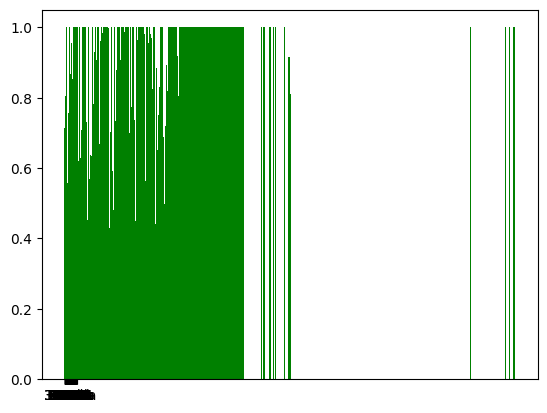

In [12]:
# 8) Koliki je prosečni, a koliki globalni koeficijent klasterizacije mreže?
# Kakva je raspodela lokalnog koeficijenta klasterizacije njenih čvorova?
# Da li je klasterisanje izraženo ili ne?
# Odgovor dati upoređivanjem sa slučajno generisanim Erdos-Renyi i scale free mrežama istih dimenzija.

#TODO

def print_and_compare_clusterization(G:nx.Graph, graph_name):

    def print_clusterization(G:nx.Graph, graph_name):
        print(f"Prosecni lokalni koeficijent klasterizacije za {graph_name} je {nx.average_clustering(G)}, a globalni je {nx.transitivity(G)}")
        clustering = nx.clustering(G)
        plt.bar(clustering.keys(), clustering.values(), 10, color='g')

    print_clusterization(G, graph_name)

    N = G.number_of_nodes()
    M = G.number_of_edges()
    analog_probability = nx.density(G)
    
    interesting_probabilities = [1 / math.log(N), analog_probability]
    ER_list = [nx.erdos_renyi_graph(N, p) for p in interesting_probabilities]
    ER_names = ["1/ln(N)", "ista verovatnoca kao u datom grafu"]
    AB = nx.barabasi_albert_graph(N, (2*M) // N)


    for ER_name, ER in zip(ER_names, ER_list):
        print_clusterization(ER, ER_name)
    print_clusterization(AB, "scale-free mreza")


print_and_compare_clusterization(L_space, "L-prostor")
print_and_compare_clusterization(C_space, "C-prostor")
print_and_compare_clusterization(P_space, "P-prostor")

#OUTPUT:
# Prosecni lokalni koeficijent klasterizacije za L-prostor je 0.01807089609006543, a globalni je 0.03316749585406302
# Prosecni lokalni koeficijent klasterizacije za 1/ln(N) je 0.12422540150658502, a globalni je 0.1242254829745278
# Prosecni lokalni koeficijent klasterizacije za ista verovatnoca kao u datom grafu je 0.0007926365434352655, a globalni je 0.0010523854069223574
# Prosecni lokalni koeficijent klasterizacije za scale-free mreza je 0.010949827598069487, a globalni je 0.003658937674724552
# Prosecni lokalni koeficijent klasterizacije za C-prostor je 0.6139194322268351, a globalni je 0.5026952069406913
# Prosecni lokalni koeficijent klasterizacije za 1/ln(N) je 0.18416917159209523, a globalni je 0.18412205844323765
# Prosecni lokalni koeficijent klasterizacije za ista verovatnoca kao u datom grafu je 0.15104635540863326, a globalni je 0.15144727773949002
# Prosecni lokalni koeficijent klasterizacije za scale-free mreza je 0.3616530044388497, a globalni je 0.34726646853819676
# Prosecni lokalni koeficijent klasterizacije za P-prostor je 0.7571769606905687, a globalni je 0.4723968113751248
# Prosecni lokalni koeficijent klasterizacije za 1/ln(N) je 0.1241903762835847, a globalni je 0.1241880275161438
# Prosecni lokalni koeficijent klasterizacije za ista verovatnoca kao u datom grafu je 0.03882982128959097, a globalni je 0.03883566125599462
# Prosecni lokalni koeficijent klasterizacije za scale-free mreza je 0.14470940820224246, a globalni je 0.147254189367977

#Zakljucci:
#L_Space: klasterizacija nije izrazena, P i C prostor jesu



In [21]:
# 9) Na osnovu odgovora na pitanja 6 i 8, proceniti da li mreža iskazuje osobine malog sveta.

#TODO
def print_small_world_coefficients(G:nx.Graph, name):
    sigma = nx.sigma(G, niter=2)
    omega = 0
    # sigma = 0
    # omega = nx.omega(G, niter=1, nrand=1)
    print(f"Za graf {name} koeficijenti su sigma = {sigma}, omega = {omega}")

print_small_world_coefficients(L_space, "BgNetL")
print_small_world_coefficients(P_space, "BgNetP")
print_small_world_coefficients(C_space, "BgNetC")

#OUTPUT LSPACEomega = -0.5482994459788156
#Za graf BgNetL koeficijenti su sigma = 40.01195330938196, omega = 0

#BGNetL nema odlike malog sveta jer ima velik dijametar i prosecnu distancu, a malu klasterizaciju

Za graf BgNetL koeficijenti su sigma = 40.01195330938196, omega = 0


KeyboardInterrupt: 

In [7]:
# 10) Izvršiti asortativnu analizu po stepenu čvora i dati odgovor
# da li je izraženo asortativno mešanje. Priložiti i vizuelizaciju.

#TODO
def analyze_assortativity(G:nx.Graph, name):
    print(f"Koeficijent asortativnosti po stepenu za graf {name} je {nx.degree_assortativity_coefficient(G)}")
analyze_assortativity(L_space)

NameError: name 'L_space' is not defined

In [ ]:
# 11) Da li mreža ispoljava fenomen kluba bogatih (eng. rich club phenomenon)?

#TODO

In [ ]:
# 12) Analizirati stajališta na osnovu tarifne zone kojoj pripadaju.
# Ispitati da li BGNetL i BGNetP mreže odgovaraju modelu jezgra i periferije (core-periphery model).
# Smatrati da prva zona pripada jezgru, a ostale periferiji.

#TODO

In [ ]:
# 13) Kakva je distribucija čvorova po stepenu i da li prati power law raspodelu?

#TODO
def analyze_degree_distribution():
    print("LALAL")

### Analiza mera centralnosti [5 poena]
14) Sprovesti analize centralnosti po stepenu, bliskosti i relacionoj centralnosti. Dati pregled najvažnijih aktera po svakoj od njih.
15) Ko su najvažniji akteri po centralnosti po sopstvenom vektoru? Šta nam to govori o njima?
16) Na osnovu prethodna dva pitanja predložiti i konstruisati heuristiku (kompozitnu meru centralnosti) za pronalaženje najvažnijih aktera i pronaći ih. Obratiti pažnju na tip mreže koji se analizira (usmerena ili neusmerena) i, shodno tome, prilagoditi koliko različite mrežne metrike utiču na heuristiku.

In [ ]:
# 14) Sprovesti analize centralnosti po stepenu, bliskosti i relacionoj centralnosti.
# Dati pregled najvažnijih aktera po svakoj od njih.

# TODO

In [ ]:
# 15) Ko su najvažniji akteri po centralnosti po sopstvenom vektoru? Šta nam to govori o njima?

# TODO

In [ ]:
# 16) Na osnovu prethodna dva pitanja predložiti i konstruisati heuristiku (kompozitnu meru centralnosti)
# za pronalaženje najvažnijih aktera i pronaći ih. Obratiti pažnju na tip mreže koji se analizira (usmerena ili neusmerena) i,
# shodno tome, prilagoditi koliko različite mrežne metrike utiču na heuristiku.

# TODO

### Detekcija komuna Luvenskom metodom [5 poena]
17) Sprovesti klasterisanje Luvenskom metodom (maksimizacijom modularnosti) u alatu Gephi za tri različite vrednosti parametra rezolucije. Konstruisati vizuelizacije i diskutovati izbor parametra rezolucije na dobijeno klasterisanje (broj i veličina klastera).
18) Koje zajednice (komune) se mogu uočiti prilikom analize mreže, a koji akteri su ključni brokeri? Da li postoji neko objašnjenje za detektovane komune? Odgovor dati posmatrajući ne samo strukturu mreže, već i atribute preračunate u pitanjima 3 i 4.

In [ ]:
# 17) Sprovesti klasterisanje Luvenskom metodom (maksimizacijom modularnosti) u alatu Gephi za tri različite vrednosti parametra rezolucije.
# Konstruisati vizuelizacije i diskutovati izbor parametra rezolucije na dobijeno klasterisanje (broj i veličina klastera).

# TODO

In [ ]:
# 18) Koje zajednice (komune) se mogu uočiti prilikom analize mreže, a koji akteri su ključni brokeri?
# Da li postoji neko objašnjenje za detektovane komune?
# Odgovor dati posmatrajući ne samo strukturu mreže, već i atribute preračunate u pitanjima 3 i 4.

# TODO

### Detekcija komuna spektralnim klasterisanjem [10 poena]
19) Predložiti funkcije sličnosti za L i P modele koje, osim strukturnih informacija iz odgovarajućih mreža, uključuju i geografske podatke o čvorovima i konstruisati matrice sličnosti i graf Laplasijane na osnovu predloženih funkcija sličnosti.
20) Sprovesti sprektralnu analizu i proceniti potencijalne kandidate za broj komuna u mreži. Uporediti rezultat sa dendogramom konstruisanim Girvan-Newman metodom.
21) Izvršiti spektralno klasterisanje na osnovu konstruisanih funkcija sličnosti i procenjenog broja klastera. Vizuelizovati klasterisanje na mapi gradskog saobraćaja, tako što će se stanice koje su svrstane u isti klaster crtati istom bojom. Izabrati boje koje daju dobar kontrast u odnosu na mapu i boje drugih klastera.
22) Ko su akteri koji se mogu okarakterisati kao ključni brokeri (mostovi) u mreži? Šta ih čini brokerima? Porediti odgovor sa brokerima dobijenim u pitanju 17.

In [ ]:
# 19) Predložiti funkcije sličnosti za L i P modele koje, osim strukturnih informacija iz odgovarajućih mreža,
# uključuju i geografske podatke o čvorovima i konstruisati matrice sličnosti i graf Laplasijane na osnovu predloženih funkcija sličnosti.

# TODO

In [ ]:
# 20) Sprovesti sprektralnu analizu i proceniti potencijalne kandidate za broj komuna u mreži.
# Uporediti rezultat sa dendogramom konstruisanim Girvan-Newman metodom.

# TODO

In [ ]:
# 21) Izvršiti spektralno klasterisanje na osnovu konstruisanih funkcija sličnosti i procenjenog broja klastera.
# Vizuelizovati klasterisanje na mapi gradskog saobraćaja, tako što će se stanice koje su svrstane u isti klaster crtati istom bojom.
# Izabrati boje koje daju dobar kontrast u odnosu na mapu i boje drugih klastera.

# TODO

In [ ]:
# 22) Ko su akteri koji se mogu okarakterisati kao ključni brokeri (mostovi) u mreži?
# Šta ih čini brokerima?
# Porediti odgovor sa brokerima dobijenim u pitanju 17.

# TODO

### Analiza mreže BGNetLWalk [5 poena]
23) Ponoviti sve analize koje imaju smisla za BGNetLWalk mrežu. Uporediti i komentarisati dobijene rezultate sa BGNetL mrežom. Da li se uočavaju značajnije promene u mreži?

In [ ]:
# 23) Ponoviti sve analize koje imaju smisla za BGNetLWalk mrežu.
# Uporediti i komentarisati dobijene rezultate sa BGNetL mrežom.
# Da li se uočavaju značajnije promene u mreži?

# TODO: pokrenuti notebook sa drugačijim parametrima
